In [43]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from snAPI.Main import *
import pandas as pd
sys.path.append("../")
from HH import HH_T3
from Functions import *
import time

# Functions

In [130]:
def getcols(m1,nrows):
    arr=np.array([])
    for elem in np.cumsum(m1):
        rest=elem%(nrows)
        inte=elem//(nrows)
        if inte%2==1:
            a=nrows-rest
        else:
            a=rest 
        arr=np.append(arr,a)       
    return arr

f=lambda x : nrows-x%(nrows) if x//(nrows)%2==1 else x%(nrows) # this is the lambda version of getcols (much faster)

In [131]:
def positions(df,step):
    xs=np.unique(df['row'])*step
    ys=np.unique(df['col'])*step
    return xs,ys
    

# Select file

In [46]:
filename='../../../Acquisition2/Data/Trial_markers_QD/T/PTU_9.ptu'
#os.listdir(filename)

# Create data structure 

In [69]:
sn=snAPI()
sn.getDevice()
sn.getFileDevice(filename)
sn.initDevice(MeasMode.T3)
sn.unfold.setT3Format(format=UnfoldFormat.DTimesSyncCntr)
sn.unfold.measure()
times, channels = sn.unfold.getBlock()
dtimes=sn.unfold.dTime_T3(times)
markers_Bool=np.array([sn.unfold.isMarker(datai) for datai in channels])
m1=markers_Bool*sn.unfold.markers(channels)[2]
m2=markers_Bool*sn.unfold.markers(channels)[3]
m3=markers_Bool*sn.unfold.markers(channels)[1]


In [70]:
cum=np.cumsum(markers_Bool)
rm=np.array([n%2 for n in cum])
row=np.array(np.cumsum(m2),dtype=int)
df=pd.DataFrame(np.array([dtimes,times,channels,markers_Bool,m1,m2,m3,rm]).T,columns=['dTimes','absTimes','Channels','markers','m1','m2','m3','rm'])
df['row']=row
nrows=np.sum(df['m1'][df['row']==2])
col=np.array([f(x) for x in np.cumsum(m1)],dtype=int)
df['col']=col

In [118]:


df['cm3']=np.cumsum(df['m3'])
data= df[df['rm'] !=1]
data=data[data['Channels']==3]
data=data[data['cm3']!=0]#remove data before starting measurement (data start after the first m3 marker)
data=data.drop(columns=['m1', 'm2','m3','markers','rm'])

In [119]:
data

,dTimes,absTimes,Channels,row,col,cm3
1907,1423.0,6.022021e+10,3.0,0,1,1.0
1908,275.0,6.022087e+10,3.0,0,1,1.0
1909,266.0,6.022129e+10,3.0,0,1,1.0
1910,271.0,6.024430e+10,3.0,0,1,1.0
1911,268.0,6.024941e+10,3.0,0,1,1.0
...,...,...,...,...,...,...
1586357,286.0,2.054002e+13,3.0,49,0,2499.0
1586358,277.0,2.054002e+13,3.0,49,0,2499.0
1586359,2850.0,2.054003e+13,3.0,49,0,2499.0
1586360,277.0,2.054004e+13,3.0,49,0,2499.0


# X Y positions: ROW an COLs

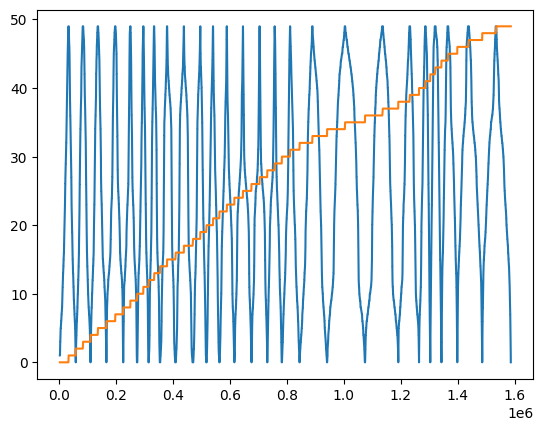

In [132]:
plt.plot(data['col'])
plt.plot(data['row'])

# Reconstruct image

In [120]:
xs=np.unique(df['row'])
ys=np.unique(df['col'])
M=np.zeros((np.size(xs),np.size(ys)))
for xi in xs:
    for yi in ys:
        M[xi,yi]=np.size(data['dTimes'][(data['row']==xi)&(data['col']==yi)])


In [121]:
x,y=positions(df,0.2)

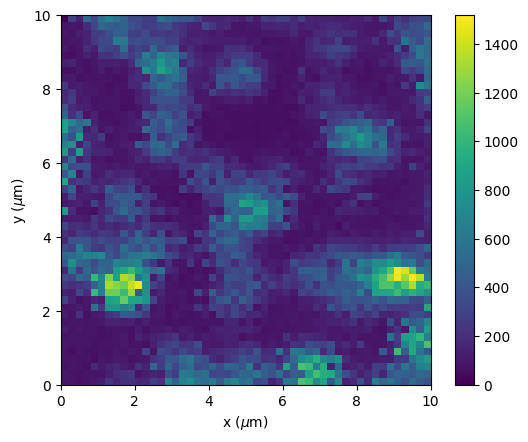

In [122]:
plt.imshow(M,extent=[0,10,0,10])
plt.xlabel('x ($\mu$m)')
plt.ylabel('y ($\mu$m)')
plt.colorbar()

# Analyze individual pixel

In [133]:
d=data[(data['row']==10)&(data['col']==10)]

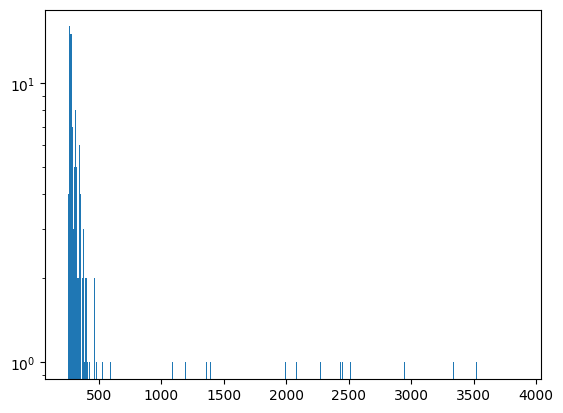

In [134]:
plt.hist(d['dTimes'],bins=500);
plt.yscale('log')

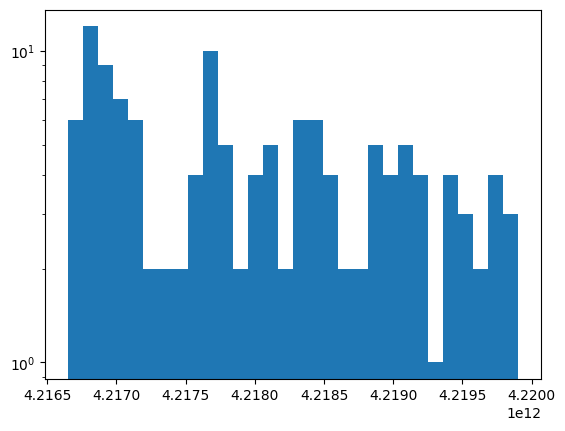

In [138]:
plt.hist(d['absTimes'],bins=30);
plt.yscale('log')